In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import cv2
import numpy as np
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import glob
import sklearn.metrics
import seaborn as sns
from keras.models import load_model
from google.colab import drive
from tqdm.notebook import tqdm
from skimage.color import rgb2gray
from skimage.transform import resize
import pickle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
import time
from tensorflow.keras.callbacks import * 
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
#upzip base file
!unzip -qq "/content/drive/MyDrive/OCT_SM/OCT_small(1).zip"

In [4]:
total_dir = "/content/OCT_small"
train_dir = "/content/OCT_small/train"
test_dir = "/content/OCT_small/test"
classes = os.listdir(train_dir)

dataset = {
    "img_path" : [], 
    "class" : [], 
    "split" : []
}

for split in os.listdir(total_dir):
  for where in os.listdir(total_dir + "/" + split):
    for image in glob.glob(total_dir+"/"+split+"/"+where+"/*.jpeg"):
      dataset["img_path"].append(image)
      dataset["class"].append(where)
      dataset["split"].append(split)

dataset = pd.DataFrame(dataset)
dataset = dataset.sample(frac=1, random_state = 77)
dataset.head()

,img_path,class,split
2977,/content/OCT_small/train/NORMAL/NORMAL-8006306...,NORMAL,train
1746,/content/OCT_small/test/NORMAL/NORMAL-9301250-...,NORMAL,test
3189,/content/OCT_small/train/NORMAL/NORMAL-4677727...,NORMAL,train
4682,/content/OCT_small/train/NORMAL/NORMAL-5074580...,NORMAL,train
1594,/content/OCT_small/test/NORMAL/NORMAL-3361560-...,NORMAL,test


In [5]:
train_df = dataset[dataset["split"] == "train"]
test_df = dataset[dataset["split"] == "test"]
valid_df = dataset[dataset["split"] == "validation"]
print(test_df.head(10))
print("len train_df : ", len(train_df))
print("len test_df : ", len(test_df))
print("len valid_df : ", len(valid_df))

                                               img_path   class split
1746  /content/OCT_small/test/NORMAL/NORMAL-9301250-...  NORMAL  test
1594  /content/OCT_small/test/NORMAL/NORMAL-3361560-...  NORMAL  test
1474  /content/OCT_small/test/NORMAL/NORMAL-904493-1...  NORMAL  test
2061   /content/OCT_small/test/CNV/CNV-9598696-146.jpeg     CNV  test
2090     /content/OCT_small/test/CNV/CNV-1986974-3.jpeg     CNV  test
833   /content/OCT_small/test/DRUSEN/DRUSEN-4310081-...  DRUSEN  test
975   /content/OCT_small/test/NORMAL/NORMAL-3758622-...  NORMAL  test
1021  /content/OCT_small/test/NORMAL/NORMAL-5574030-...  NORMAL  test
1975  /content/OCT_small/test/NORMAL/NORMAL-4379133-...  NORMAL  test
2086    /content/OCT_small/test/CNV/CNV-2034494-78.jpeg     CNV  test
len train_df :  4995
len test_df :  1425
len valid_df :  709


Text(0.5, 1.0, 'Validation Dataset')

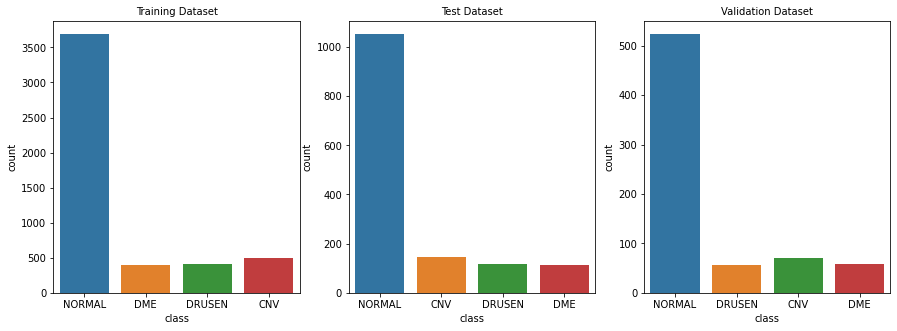

In [6]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=train_df["class"])
plt.title("Training Dataset", size=10)

plt.subplot(1, 3, 2)
sns.countplot(x=test_df["class"])
plt.title("Test Dataset", size=10)

plt.subplot(1, 3, 3)
sns.countplot(x=valid_df["class"])
plt.title("Validation Dataset", size=10)

In [7]:
X_train = train_df["img_path"]
y_train = train_df["class"]

X_test = test_df["img_path"]
y_test = test_df["class"]

X_val = valid_df["img_path"]
y_val = valid_df["class"]

for name in list(train_df["class"].unique()):
  print(name, len(train_df[train_df["class"] == name]))
print(" ------------------------------------------------- ")
for name in list(test_df["class"].unique()):
  print(name, len(test_df[test_df["class"] == name]))
print(" ------------------------------------------------- ")
for name in list(valid_df["class"].unique()):
  print(name, len(valid_df[valid_df["class"] == name]))
print(" ------------------------------------------------- ")

NORMAL 3692
DME 396
DRUSEN 410
CNV 497
 ------------------------------------------------- 
NORMAL 1053
CNV 144
DRUSEN 116
DME 112
 ------------------------------------------------- 
NORMAL 524
DRUSEN 56
CNV 71
DME 58
 ------------------------------------------------- 


In [8]:
def norm_digit(img):
    m = cv2.moments(img)
    cx = m['m10'] / m['m00']
    cy = m['m01'] / m['m00']
    h, w = img.shape[:2]
    aff = np.array([[1, 0, w/2 - cx], [0, 1, h/2 - cy]], dtype=np.float32)
    dst = cv2.warpAffine(img, aff, (0, 0))
    return dst

In [10]:
from tqdm.notebook import tqdm
from skimage.color import rgb2gray
from skimage.transform import resize

def img_preprocess(imgs):
  images = []
  bar_total = tqdm(imgs)
  for file in bar_total:
          
          img = cv2.imread(file, 0)
          img = np.where(img == 255, 0, img)
          img = norm_digit(img)
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
          #cl1 = cv2.fastNlMeansDenoising(img, None, 12, 7,21)
          cl1 = clahe.apply(img)
              
          images.append(resize(cl1, (224,224,3)))
          
  images = np.array(images)
  return images

In [11]:
X_train = img_preprocess(X_train)
X_test = img_preprocess(X_test)
X_val = img_preprocess(X_val)

In [12]:
from sklearn.preprocessing import LabelEncoder

def makelabel(labels):
  encoder = LabelEncoder()
  encoder.fit(labels)
  labels_encoded = encoder.transform(labels)
  labels_encoded[:3], encoder.classes_
  return labels_encoded

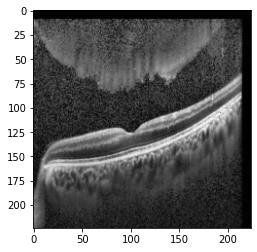

In [13]:
y_train = makelabel(y_train)
y_test = makelabel(y_test)
y_val = makelabel(y_val)


plt.imshow(X_train[random.choice(range(len(X_train)))])

In [28]:
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.applications.resnet50 import ResNet50
#model list 
# densenet
# efticientent
# inception_resnet_v2
# inception_v3
# mobilenet
# mobilenet_v2
# movilenet_v3
# nasnet
# resnet
# resnet50
IMG_SIZE = 224
mymodel = ResNet50(weights= "imagenet", 
                    include_top = False, 
                    input_shape = (IMG_SIZE, IMG_SIZE, 3),
                    pooling = "avg")
testmodel = models.Sequential()
testmodel.add(mymodel)
testmodel.add(Dense(4, activation="softmax"))
testmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [29]:
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)
testmodel.compile(optimizer=optimizers,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
rlr_cb = ReduceLROnPlateau(monitor='val_accuracy',factor=0.3, patience=10, mode='max',verbose=1)
ely_cb = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False)
mc = ModelCheckpoint('test_model.h5', monitor='val_loss', mode='min', save_best_only=True)

#원하는 callbacks 채워 넣으세요!
start_time = time.time()
hist=testmodel.fit(X_train, y_train.reshape(-1, 1),
              epochs=200, verbose=1, batch_size = 140,
              validation_data = (X_test, y_test.reshape(-1, 1)), shuffle=True,
              callbacks=[rlr_cb])
print('fit time : ', time.time() - start_time )

Epoch 1/200
36/36 [==============================] - 49s 773ms/step - loss: 0.5004 - accuracy: 0.8492 - val_loss: 424.9411 - val_accuracy: 0.7389
Epoch 2/200
36/36 [==============================] - 25s 703ms/step - loss: 0.1710 - accuracy: 0.9499 - val_loss: 1.4453 - val_accuracy: 0.7389
Epoch 3/200
36/36 [==============================] - 25s 703ms/step - loss: 0.1147 - accuracy: 0.9646 - val_loss: 0.9488 - val_accuracy: 0.7389
Epoch 4/200
36/36 [==============================] - 25s 703ms/step - loss: 0.0631 - accuracy: 0.9800 - val_loss: 1.1780 - val_accuracy: 0.7389
Epoch 5/200
36/36 [==============================] - 25s 703ms/step - loss: 0.0446 - accuracy: 0.9868 - val_loss: 1.0937 - val_accuracy: 0.7389
Epoch 6/200
36/36 [==============================] - 25s 703ms/step - loss: 0.0338 - accuracy: 0.9894 - val_loss: 1.2489 - val_accuracy: 0.7389
Epoch 7/200
36/36 [==============================] - 25s 703ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 1.2904 - val_accurac

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(acc, label ='Training Accuracy')
plt.plot(val_acc, label ='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.title('training and validation accuracy')


plt.subplot(2,1,2)
plt.plot(loss, label ='Training loss')
plt.plot(val_loss, label ='validation loss')
plt.legend(loc='lower right')
plt.ylabel('loss')
plt.title('training and validation loss')

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

testmodel.evaluate(X_test, y_test)
pred = testmodel.predict(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(y_val, pred)

print(accuracy_score(y_val, pred))
confusion_matrix(y_val, pred)

In [ ]:
#matirx 시각화
cm = sklearn.metrics.confusion_matrix(y_val, pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()